#Exploratory data analysis for image embedding

We will be experienmenting different silimary score using different network and different classes.

##Image preprocessing

In [1]:
import tensorflow as tf
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
WIDTH = 125
HEIGHT = 125

In [3]:
def resize(img):
  width, height = img.size
  if height < width:
    h_percent = HEIGHT/height
    new_width = int(width * h_percent)
    return img.resize((new_width, HEIGHT), Image.LANCZOS)
  else:
    w_percent = WIDTH/width
    new_height = int(height * w_percent)
    return img.resize((WIDTH, new_height), Image.LANCZOS)

In [4]:
def central_crop(img):
    width, height = img.size
    upper_bound_h = int(HEIGHT/2)
    lower_bound_h = HEIGHT - int(HEIGHT/2)
    upper_bound_w = int(WIDTH/2)
    lower_bound_w = WIDTH - int(WIDTH/2)
    top = int(height/2) - upper_bound_h
    bottom = int(height/2) + lower_bound_h
    left = int(width/2) - upper_bound_w
    right = int(width/2) + lower_bound_w
    return img.crop((left, top, right, bottom))

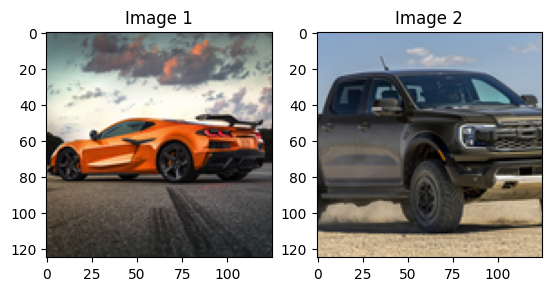

In [152]:
img1 = Image.open('car1.jpg')
img2 = Image.open('car2.jpg')
img1 = central_crop(resize(img1))
img2 = central_crop(resize(img2))
plt.subplot(121)
plt.imshow(np.asarray(img1))
plt.title("Image 1")
plt.subplot(122)
plt.imshow(np.asarray(img2))
plt.title("Image 2")
plt.show()

In [153]:
car1 = Image.open('car1.jpg')
car2 = Image.open('car2.jpg')
out1 = Image.open('outdoor1.jpg')
out2 = Image.open('outdoor2.jpg')
cty1 = Image.open('city1.jpeg')
cty2 = Image.open('city2.jpeg')
pop1 = Image.open('people1.jpeg')
pop2 = Image.open('people2.jpeg')

car1 = central_crop(resize(car1))
car2 = central_crop(resize(car2))
out1 = central_crop(resize(out1))
out2 = central_crop(resize(out2))
cty1 = central_crop(resize(cty1))
cty2 = central_crop(resize(cty2))
pop1 = central_crop(resize(pop1))
pop2 = central_crop(resize(pop2))

batch_input = np.concatenate((
    np.asarray(car1)[np.newaxis, ...],
    np.asarray(car2)[np.newaxis, ...],
    np.asarray(out1)[np.newaxis, ...],
    np.asarray(out2)[np.newaxis, ...],
    np.asarray(cty1)[np.newaxis, ...],
    np.asarray(cty2)[np.newaxis, ...],
    np.asarray(pop1)[np.newaxis, ...],
    np.asarray(pop2)[np.newaxis, ...],
    ))

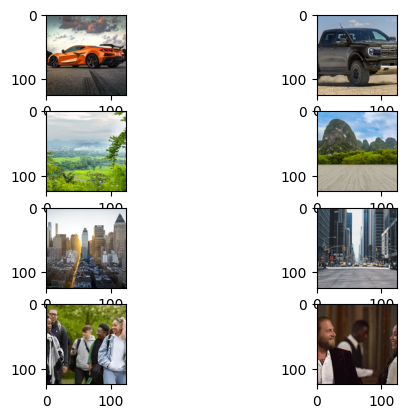

In [154]:
plt.subplot(421)
plt.imshow(car1)
plt.subplot(422)
plt.imshow(car2)
plt.subplot(423)
plt.imshow(out1)
plt.subplot(424)
plt.imshow(out2)
plt.subplot(425)
plt.imshow(cty1)
plt.subplot(426)
plt.imshow(cty2)
plt.subplot(427)
plt.imshow(pop1)
plt.subplot(428)
plt.imshow(pop2)

plt.show()

##Experiments

#### Scoring functions

In [166]:
def get_cosine_score(a,b):
  normalize_a = tf.nn.l2_normalize(a,0)
  normalize_b = tf.nn.l2_normalize(b,0)
  cos_similarity=tf.reduce_sum(tf.multiply(normalize_a,normalize_b))
  return cos_similarity.numpy()

def l2_distance(a,b):
  return tf.norm(a-b, ord='euclidean')

def get_avg_cosine_score(a,b):
  score = 0
  num = 0
  for tensor1 in a:
    for tensor2 in b:
      s = get_cosine_score(tensor1, tensor2)
      if s < 0.90:
        score += s
        num += 1
  return score/num

def get_avg_l2_score(a,b):
  score = 0
  num = 0
  for tensor1 in a:
    for tensor2 in b:
      s = l2_distance(tensor1, tensor2)
      if s > 0.1:
        score += s
        num += 1
  return score/num

def plot_cosine_result(**kargs):
  classes = list(kargs.keys())
  num_classes = len(classes)
  result = np.zeros((num_classes,num_classes))
  for i in range(len(classes)):
    for j in range(len(classes)):
      c_1 = kargs.get(classes[i])
      c_2 = kargs.get(classes[j])
      result[i][j] = get_avg_cosine_score(c_1, c_2)
  return pd.DataFrame(result, columns=classes, index=classes)

def plot_l2_result(**kargs):
  classes = list(kargs.keys())
  num_classes = len(classes)
  result = np.zeros((num_classes,num_classes))
  for i in range(len(classes)):
    for j in range(len(classes)):
      c_1 = kargs.get(classes[i])
      c_2 = kargs.get(classes[j])
      result[i][j] = get_avg_l2_score(c_1, c_2)
  return pd.DataFrame(result, columns=classes, index=classes)



#### model (ResNet50)

In [4]:
encoder = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(WIDTH, HEIGHT, 3),
)

inputs = tf.keras.layers.Input((WIDTH, HEIGHT, 3))
outputs = encoder(inputs)
outputs = tf.keras.layers.Flatten()(outputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 125, 125, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
Total params: 23587712 (89.98 MB)
Trainable params: 23534592 (89.78 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [157]:
embeddings = model(batch_input)

##### Distance score on different classes

Text(0.5, 1.0, 'L2 distance')

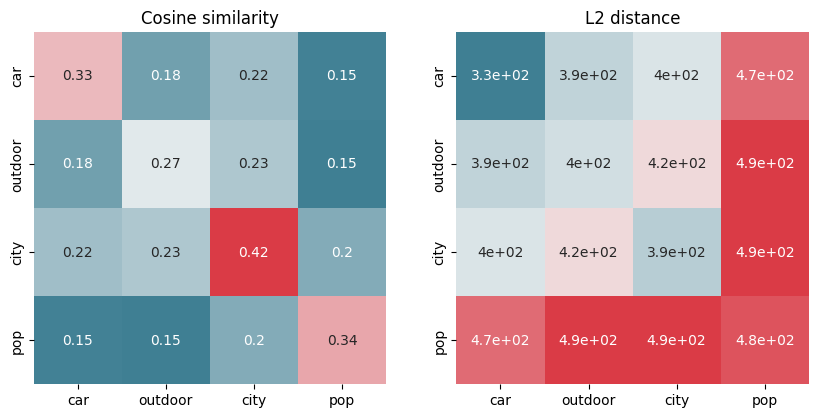

In [167]:

cosine_df = plot_cosine_result(
    car=embeddings[:2],
    outdoor=embeddings[2:4],
    city=embeddings[4:6],
    pop=embeddings[6:8]
    )

l2_df = plot_l2_result(
    car=embeddings[:2],
    outdoor=embeddings[2:4],
    city=embeddings[4:6],
    pop=embeddings[6:8])

fig, ax = plt.subplots(1, 2, figsize=(10,7))

sns.heatmap(cosine_df,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    square=True,
    annot=True,
    ax=ax[0],
    cbar=False
    )
ax[0].set_title('Cosine similarity')

sns.heatmap(l2_df,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    square=True,
    annot=True,
    ax=ax[1],
    cbar=False
    )
ax[1].set_title('L2 distance')

##### Random check

Cosine similarity: 0.32758983969688416
L2 distance: 332.8226013183594


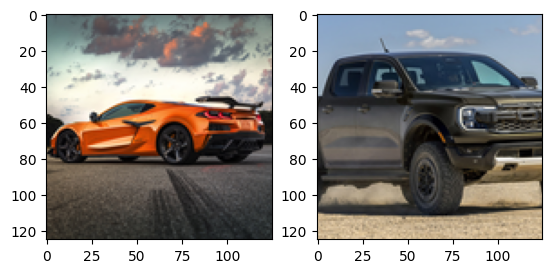

In [146]:
img1 = Image.open('car1.jpg')
img2 = Image.open('car2.jpg')
img1 = central_crop(resize(img1))
img2 = central_crop(resize(img2))
batch_input = np.concatenate((
    np.asarray(img1)[np.newaxis, ...],
    np.asarray(img2)[np.newaxis, ...]
))
embeddings = model(batch_input)
cosine_score = get_cosine_score(embeddings[0], embeddings[1])
l2_distance = l2_distance(embeddings[0], embeddings[1])

plt.subplot(121)
plt.imshow(img1)
plt.subplot(122)
plt.imshow(img2)

print(f"Cosine similarity: {cosine_score}")
print(f"L2 distance: {l2_distance}")
plt.show()

## Exporting the model in Graph format

In [7]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.9/189.9 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 75.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 85.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 38.7 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Succ

In [5]:
model.save('model')

In [7]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_node_names='encoder' \
    --saved_model_tags=serve \
    model \
    jsmodel

2023-08-05 06:41:50.513824: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:
!zip -r model.zip jsmodel

  adding: jsmodel/ (stored 0%)
  adding: jsmodel/model.json (deflated 95%)
  adding: jsmodel/group1-shard17of23.bin (deflated 7%)
  adding: jsmodel/group1-shard23of23.bin (deflated 7%)
  adding: jsmodel/group1-shard19of23.bin (deflated 7%)
  adding: jsmodel/group1-shard21of23.bin (deflated 7%)
  adding: jsmodel/group1-shard18of23.bin (deflated 7%)
  adding: jsmodel/group1-shard15of23.bin (deflated 7%)
  adding: jsmodel/group1-shard14of23.bin (deflated 7%)
  adding: jsmodel/group1-shard7of23.bin (deflated 7%)
  adding: jsmodel/group1-shard13of23.bin (deflated 7%)
  adding: jsmodel/group1-shard8of23.bin (deflated 7%)
  adding: jsmodel/group1-shard20of23.bin (deflated 7%)
  adding: jsmodel/group1-shard9of23.bin (deflated 7%)
  adding: jsmodel/group1-shard12of23.bin (deflated 7%)
  adding: jsmodel/group1-shard6of23.bin (deflated 7%)
  adding: jsmodel/group1-shard1of23.bin (deflated 7%)
  adding: jsmodel/group1-shard2of23.bin (deflated 7%)
  adding: jsmodel/group1-shard11of23.bin (deflated 

In [9]:
from google.colab import files
files.download('model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>